# Preparación de datos para video mirta-r

In [368]:
EXECUTE_DATASET_PARTITION=False
EXECUTE_DATASET_AUGMENTATION=True

In [3]:
WORKSPACE_PATH="/home/jovyan/work"
DATA_PATH=WORKSPACE_PATH+"/data"
!ls {DATA_PATH}/media

barco-annotations.mp4  bariloche_15_julio_2017.mp4  prueba-tracker.mp4
barco.mp4	       prueba-rois.mp4


In [65]:
VIDEO_FILE = DATA_PATH+"/media/barco.mp4"

In [4]:
# Path del dataset sin aumentado
DATASET_PATH=DATA_PATH+"/datasets/mirtar"

# Path del dataset aumentado
DATASET_AUG_PATH = DATASET_PATH+"-aug"

In [365]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os

## 1. Partición train-test

In [60]:
def train_test_split_frames(cap,dataset_sz = None,test_split = 0.3):
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    dataset_sz = total_frames if dataset_sz is None else dataset_sz
    data = np.random.randint(total_frames, size=dataset_sz)
    indices = np.random.permutation(data.shape[0])
    i0 = int(dataset_sz*(1.-test_split))
    train_idx, test_idx = indices[:i0], indices[i0:]
    train, test = data[train_idx], data[test_idx]    
    return train,test

def save_images(cap, dst_path,img_frames):
    for x in img_frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES,x)
        ret, frame = cap.read()
        img_filename = dst_path+"/img{}.jpg".format(x)
        cv2.imwrite(img_filename, frame)

In [69]:
if EXECUTE_DATASET_PARTITION:
    !rm -rf {DATASET_PATH}
    !mkdir -pv {DATASET_PATH}/train
    !mkdir -pv {DATASET_PATH}/test

    cap = cv2.VideoCapture(VIDEO_FILE)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print("Total:", total_frames)
    dataset_total_frames = 50
    train,test =  train_test_split_frames(cap,dataset_sz = dataset_total_frames,test_split = 0.3)
    print("Train:", train.shape[0])
    print("Test:", test.shape[0])

    save_images(cap, DATASET_PATH+"/train",train)
    save_images(cap, DATASET_PATH+"/test",test)

    cap.release()
else:
    print("Dataset partition **NOT** executed. Checking")

mkdir: created directory '/home/jovyan/work/data/datasets/mirtar'
mkdir: created directory '/home/jovyan/work/data/datasets/mirtar/train'
mkdir: created directory '/home/jovyan/work/data/datasets/mirtar/test'
Total: 18205
Train: 35
Test: 15


## 2. Etiquetado (manual)

El paso de etiquetado es manual. 
- Por simplicidad, se realizó con [labelImg](https://github.com/tzutalin/labelImg) eligiendo YOLO como formato de exportación.
- Se descartó el uso de una herramienta más potente: [Computer Vision Annotation Tool (CVAT)](https://cvat.org/) por el consumo excesivo de recursos para la PC con que se trabajó, pero parece ser la opción más conveniente si se configura adecuadamente un entorno de preparación de datasets para múltiples usuarios y proyectos.

~~~bash
pip3 install labelImg
labelImg
~~~

In [6]:
!ls {DATASET_PATH}

test  train


In [7]:
!ls {DATASET_PATH}/train

classes.txt   img11892.jpg  img1480.txt   img1993.jpg  img7853.txt
img10062.jpg  img11892.txt  img15966.jpg  img1993.txt  img7983.jpg
img10062.txt  img1242.jpg   img15966.txt  img226.jpg   img7983.txt
img10550.jpg  img1242.txt   img16051.jpg  img226.txt   img8052.jpg
img10550.txt  img12477.jpg  img16051.txt  img2529.jpg  img8052.txt
img11233.jpg  img12477.txt  img16203.jpg  img2529.txt  img8469.jpg
img11233.txt  img12933.jpg  img16203.txt  img340.jpg   img8469.txt
img11278.jpg  img12933.txt  img17540.jpg  img340.txt   img8619.jpg
img11278.txt  img13051.jpg  img17540.txt  img3929.jpg  img8619.txt
img11474.jpg  img13051.txt  img17679.jpg  img3929.txt  img9926.jpg
img11474.txt  img13650.jpg  img17679.txt  img4262.jpg  img9926.txt
img11607.jpg  img13650.txt  img17877.jpg  img4262.txt
img11607.txt  img13852.jpg  img17877.txt  img5239.jpg
img1178.jpg   img13852.txt  img18082.jpg  img5239.txt
img1178.txt   img1480.jpg   img18082.txt  img7853.jpg


In [8]:
!ls {DATASET_PATH}/test

img12115.jpg  img1603.jpg   img2264.jpg  img5320.jpg  img8243.jpg
img12419.jpg  img16322.jpg  img2334.jpg  img7463.jpg  img8722.jpg
img15269.jpg  img16689.jpg  img365.jpg	 img8240.jpg  img9859.jpg


## 3. Aumentado de dataset

In [235]:
def load_class_labels(filename):
    with open(filename) as f:
        content = f.readlines()
    class_labels = [ x.split()[0] for x in content]
    return class_labels

In [236]:
class_labels = load_class_labels("{}/train/classes.txt".format(DATASET_PATH))
class_labels

['operador', 'red', 'pescado']

In [237]:
class_label_2_idx = { label:idx for idx,label in enumerate(class_labels)}
class_label_2_idx

{'operador': 0, 'red': 1, 'pescado': 2}

In [238]:
import imgaug as ia
import imageio
import imgaug.augmenters as iaa

from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

ia.seed(42)

In [239]:
def load_img_with_bbs(img_path, img_name):
    """ Carga imagen con bounding boxes anotadas en formato YOLO (en mismo formato que las deja labelImg)
    """
    image = imageio.imread("{}{}.jpg".format(img_path,img_name))
    img_bbs = []
    with open("{}{}.txt".format(img_path,img_name)) as f:
        content = f.readlines()
    for x in content:
        x = x.split(" ")
        class_idx,xc,yc,w,h=int(x[0]),float(x[1]),float(x[2]),float(x[3]),float(x[4])    
        x1 = (xc-w/2)*image.shape[1]
        y1 = (yc-h/2)*image.shape[0]
        x2 = (xc+w/2)*image.shape[1]
        y2 = (yc+h/2)*image.shape[0]
        img_bbs.append(BoundingBox(x1=x1,x2=x2,y1=y1,y2=y2, label=class_labels[class_idx]))        
    img_bbs = BoundingBoxesOnImage(img_bbs, shape=image.shape) 
    return image,img_bbs

In [ ]:
img_path = DATASET_PATH+"/train/"
img_name="img226"
image,img_bbs = load_img_with_bbs(img_path,img_name)
ia.imshow(img_bbs.draw_on_image(image,size=2))

In [ ]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.1, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.5), per_channel=0.2),
    
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-30, 30),
        shear=(-10, 10)
    )
], random_order=True) # apply augmenters in random order

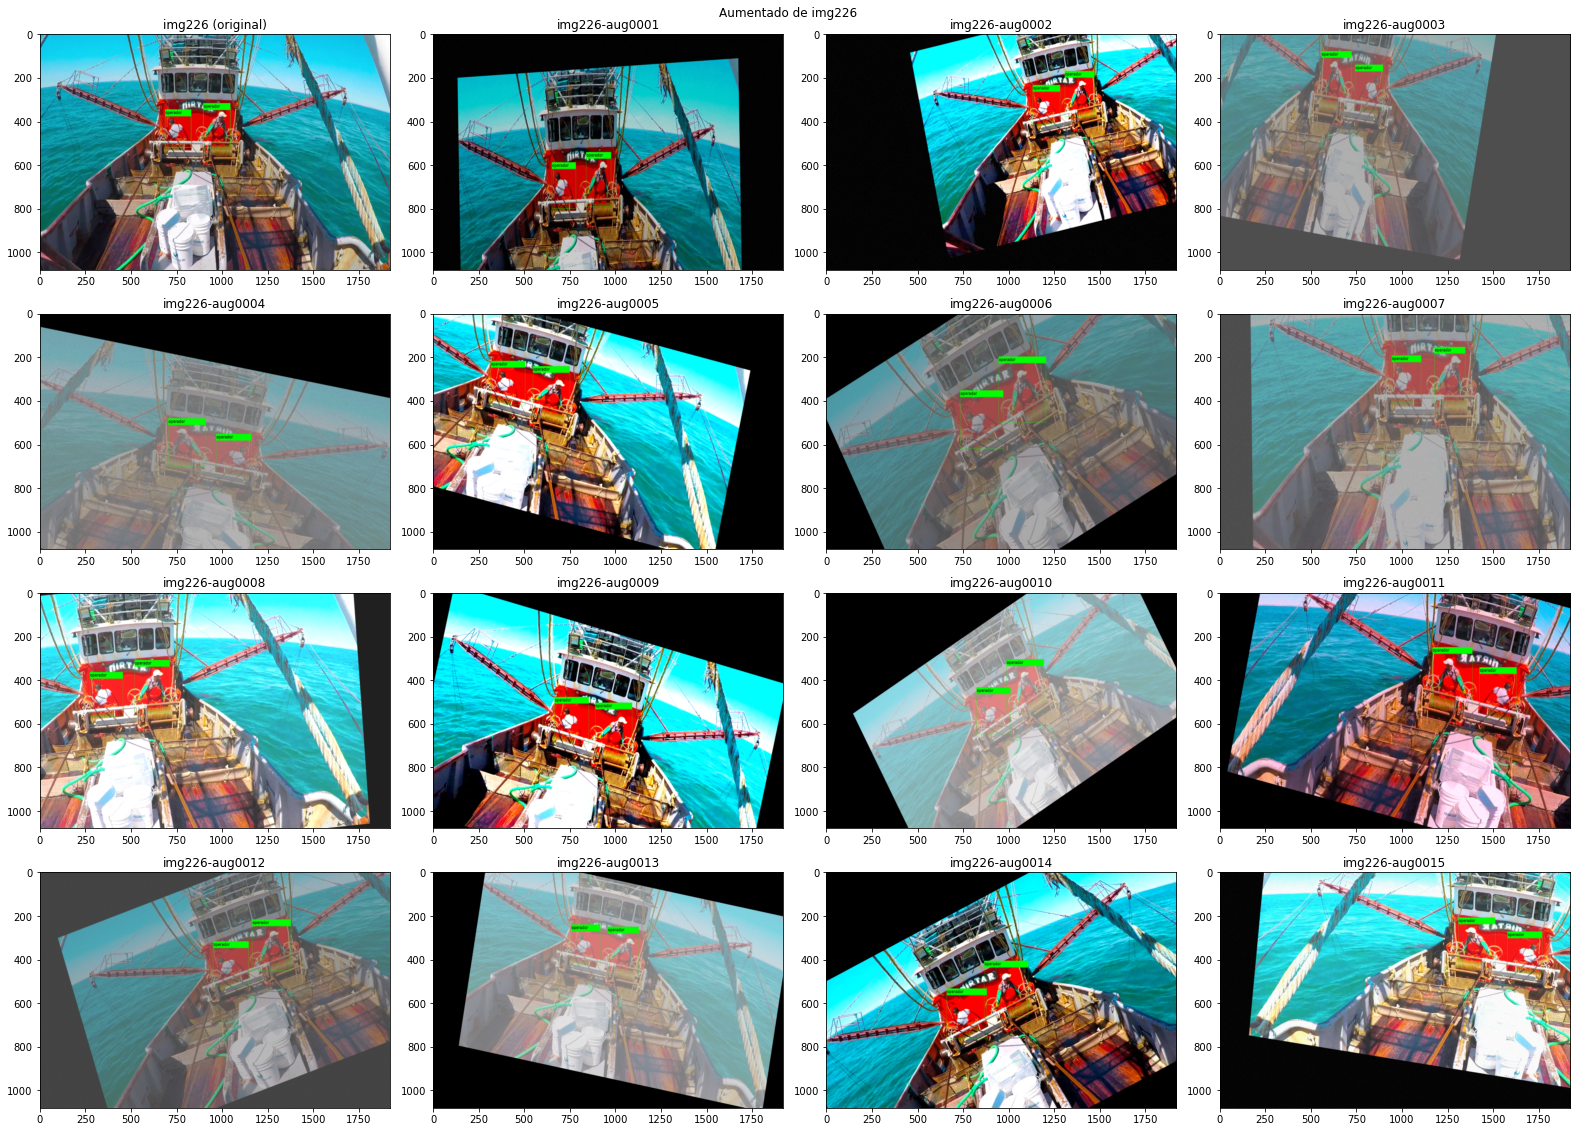

In [371]:
def imgaug_bb_format_to_yolo(bbs_aug,img_w,img_h):
    bbs_yolo = []
    # aug bbs
    for bb in bbs_aug:    
        label = class_label_2_idx[bb.label]
        w = (bb.x2-bb.x1)/img_w
        h = (bb.y2-bb.y1)/img_h
        xc = bb.x1/img_w+w/2
        yc = bb.y1/img_h+h/2
        
        bbs_yolo.append([label,xc,yc,w,h])
    return bbs_yolo

def augment_image(img_name,img_src_path,img_dst_path,n_aug = 2,visualize=False,dry_run=False):
    image,img_bbs = load_img_with_bbs(img_src_path,img_name)

    if visualize:
        nx = 4
        ny = int((n_aug+1)/nx)
        fig,axes=plt.subplots(ny,nx,figsize=(22,ny*4))
        axes[0][0].imshow(img_bbs.draw_on_image(image, size=2), interpolation='bilinear', aspect='auto')
        axes[0][0].set_title(img_name+" (original)")

    for i in range(1,n_aug+1):
        image_aug, bbs_aug = seq(image=image, bounding_boxes=img_bbs)
        bbs_aug = bbs_aug.remove_out_of_image().clip_out_of_image()
        #for bb in bbs_aug:
        #   print(bb.label,bb.x1,bb.y1,bb.x2,bb.y2,image_aug.shape)
        
        # aug image
        if not dry_run:
            aug_filename = "{}/{}-aug{:04d}".format(img_dst_path,img_name,i)
            imageio.imwrite(aug_filename+".jpg", image_aug)        
            # aug bbs
            bbs_yolo = imgaug_bb_format_to_yolo(bbs_aug,image_aug.shape[1],image_aug.shape[0])
            bb_lines = ["{:d} {:0.6f} {:0.6f} {:0.6f} {:0.6f}".format(*bb) for bb in bbs_yolo]        
            with open(aug_filename+".txt","w") as f:
                f.writelines("%s\n" % l for l in bb_lines)
        
        if visualize:
            iy = int(i/nx)
            ix = int(i%nx)
            axes[iy][ix].imshow(bbs_aug.draw_on_image(image_aug), interpolation='bilinear', aspect='auto')
            axes[iy][ix].set_title("{}-aug{:04d}".format(img_name,i))
            
    if visualize:
        fig.suptitle("Aumentado de {}".format(img_name))
        fig.tight_layout()
            
img_src_path = DATASET_PATH+"/train/"
img_dst_path = DATASET_AUG_PATH+"/train/"
img_name="img226"        
augment_image(img_name,img_src_path,img_dst_path,n_aug = 15,visualize=True,dry_run=True)

In [373]:
img_src_path = DATASET_PATH+"/train/"
img_dst_path = DATASET_AUG_PATH+"/train/"
n_aug = 15

if EXECUTE_DATASET_AUGMENTATION:
    !rm -rf {DATASET_AUG_PATH}
    !mkdir -pv {DATASET_AUG_PATH}/train
    !mkdir -pv {DATASET_AUG_PATH}/test
    !cp {DATASET_PATH}/train/classes.txt {DATASET_AUG_PATH}/train/classes.txt
    
    img_files = [os.path.splitext(os.path.basename(x))[0] for x in glob.glob(img_src_path+"/*.jpg")]
    for img_name in img_files:
        print(img_name)
        augment_image(img_name,img_src_path,img_dst_path,visualize=False,dry_run=False)
    
    # El dataset de test es igual
    !cp -r {DATASET_PATH}/test {DATASET_AUG_PATH}/test

mkdir: created directory '/home/jovyan/work/data/datasets/mirtar-aug'
mkdir: created directory '/home/jovyan/work/data/datasets/mirtar-aug/train'
mkdir: created directory '/home/jovyan/work/data/datasets/mirtar-aug/test'
img5239
img17679
img8469
img7983
img12933
img11233
img13650
img1480
img3929
img9926
img10550
img2529
img18082
img1993
img8619
img11892
img16203
img340
img17540
img12477
img1242
img13051
img7853
img17877
img15966
img1178
img11607
img226
img4262
img13852
img16051
img8052
img11474
img10062
img11278
